In [2]:
from collections import deque
#Generic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Scipy package relevant to signal processing
from scipy.stats.mstats import zscore
from scipy.stats import skew,kurtosis

from scipy.signal import lfilter, cheby2, butter, argrelmax, argrelmin
from scipy.interpolate import interp1d  
from scipy.fftpack import fft
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from operator import itemgetter

#Unverified third party functions
import jade
from params import PPG_SAMPLE_RATE, MAXIMUM_PULSE_CYCLE, MINIMUM_PULSE_CYCLE
#from keras.wrappers.scikit_learn import KerasRegressor

readings= pd.read_csv("All 30FPS Frames 02 01 19.csv")

In [3]:
# This is a dictionary that is populated with the features used 
# in the machine learning experiments. The keys if "input" are IDs of a testInstance
# as they appear in LLDC (LifeLightDataCollect)

input = {}

def extract_ppgFeatures(single_waveform, sample_rate=30):
    """
    :param single_waveform: Refers to a single pulse in a PPG signal 
    :param sample_rate: Sampling rate after cubic spline interpolation
    :return: A feature set for a single pulse
    """    
    
    length = len(single_waveform)
    
    def __next_pow2(x):
        return 1 << (x - 1).bit_length()

    # Refers to the systolic index
    maxIndex = np.argmax(single_waveform)
    
    #Refers to the minimum amplitude in the single waveform
    minimum = min(single_waveform)
    #Because the signal is 0 mean make the pulse positive
    single_waveform = single_waveform + abs(minimum)
    
    #Flip the rbw portion of the signal, so both portions are descending from the maxima
    flipped = np.flipud(single_waveform[:maxIndex])
    dbwmin = min(single_waveform[maxIndex::])
    rbwmin = min(flipped)
   
    #Calculate the first derivative and the absolute fft of the single waveform 
    derivative_1 = np.diff(single_waveform, n=1) * float(sample_rate)
    derivative_1_maxima_index = argrelmax(np.array(derivative_1))[0]
    derivative_1_minima_index = argrelmin(np.array(derivative_1))[0]
    sp_mag = np.abs(np.fft.fft(single_waveform, n=__next_pow2(len(single_waveform)) * 16))
    freqs = np.fft.fftfreq(len(sp_mag))
    sp_mag_maxima_index = argrelmax(sp_mag)[0]
    
    # From here all features that get appended in the order of the feature extraction documentation
    features = []
    widthVariable = 0
    # Width - New Set of features.... (Added - 25/09/18), should be tested
    # Quickfix of widths
    # To make sure both 
    
    
    dbw = single_waveform[maxIndex::]- dbwmin
    rbw = flipped - rbwmin
    
    #Calculating the heights of each 
    i,j= max(dbw),max(rbw)
    #Calculating the amplitudes where widths occur
    
    single_waveform_75 = (i * 0.75)
    single_waveform_66 = (i * (2.0 / 3.0))
    single_waveform_50= (i / 2.0)
    single_waveform_33 = (i /3.0)
    single_waveform_25 = (i / 4.0)
    single_waveform_10 = (i / 10.0)
    widthVariable = 0
    
    for value in (single_waveform[maxIndex::]-dbwmin):
        if (len(features)==0 and value >= single_waveform_75):
            widthVariable+=1
        elif(len(features)==0):
            features.append(float(widthVariable)/sample_rate)
        if (len(features)==1 and value >=single_waveform_66):
            widthVariable+=1
        elif(len(features)==1):
            features.append(float(widthVariable)/sample_rate)
        if (len(features)==2 and value >= single_waveform_50):
            widthVariable+=1
        elif(len(features)==2):
            features.append(float(widthVariable)/sample_rate)
        if(len(features)==3 and value>= single_waveform_33):
            widthVariable+=1
        elif(len(features)==3):
            features.append(float(widthVariable)/sample_rate)
        if(len(features)==4 and value>= single_waveform_25):
            widthVariable+=1
        elif(len(features)==4):
            features.append(float(widthVariable)/sample_rate)
        if(len(features)==5 and value>= single_waveform_10):
            widthVariable+=1
        elif(len(features)==5):
            features.append(float(widthVariable)/sample_rate)
            break
    """
    plt.xlim([0, len(single_waveform[maxIndex:])])
    plt.ylim([0,single_waveform[maxIndex]])
    plt.plot(single_waveform[maxIndex:]-dbwmin)
        
    plt.axhline(y=single_waveform_75, xmin=0,xmax=(features[5]/len(single_waveform[maxIndex:])))
    plt.axhline(y=single_waveform_66, xmin=0, xmax=(features[6])/len(single_waveform[maxIndex:]))
    plt.axhline(y= single_waveform_50, xmin=0 ,xmax=(features[7]/len(single_waveform[maxIndex:])))
    plt.axhline(y=single_waveform_33,xmin=0,xmax=(features[8]/len(single_waveform[maxIndex:])))
    plt.axhline(y=single_waveform_25,xmin=0,xmax=(features[9]/len(single_waveform[maxIndex:])))
    plt.axhline(y=single_waveform_10,xmin=0,xmax=features[10]/len(single_waveform[maxIndex:]))
    plt.show()
    """
    
    single_waveform_75 = (j * 0.75)
    single_waveform_66 = (j * (2.0 / 3.0))
    single_waveform_50 = (j / 2.0)
    single_waveform_33 = (j /3.0)
    single_waveform_25 = (j / 4.0)
    single_waveform_10= (j/10.0)
            
    widthVariable=0 
    for value in (flipped-rbwmin):
        if (len(features)==6 and value >= single_waveform_75):
            widthVariable+=1
        elif(len(features)==6):
            features.append(float(widthVariable)/sample_rate)
        if (len(features)==7 and value >=single_waveform_66):
            widthVariable+=1
        elif(len(features)==7):
            features.append(float(widthVariable)/sample_rate)
        if (len(features)==8 and value >= single_waveform_50):
            widthVariable+=1
        elif(len(features)==8):
            features.append(float(widthVariable)/sample_rate)
        if(len(features)==9 and value>= single_waveform_33):
            widthVariable+=1
        elif(len(features)==9):
            features.append(float(widthVariable)/sample_rate)
        if(len(features)==10 and value>= single_waveform_25):
            widthVariable+=1
        elif(len(features)==10):
            features.append(float(widthVariable)/sample_rate)
        if(len(features)==11 and value>= single_waveform_10):
            widthVariable+=1
        elif(len(features)==11):
            features.append(float(widthVariable)/sample_rate)
            break
            
            
    area_a= np.trapz(dbw)
    area_b= np.trapz(rbw)
    features.append(area_b/area_a)
    """
    plt.xlim([0, len(single_waveform[maxIndex:])])
    plt.ylim([0,single_waveform[maxIndex]])
    plt.plot(single_waveform[maxIndex:]-dbwmin)
    plt.axhline(y=single_waveform_75, xmin=0,xmax=(features[5]/len(single_waveform[maxIndex:])))
    plt.show()
    """
    return features

#Normalisation of raw signal
def normalize_matrix(matrix):
    
    count = 0
    for array in matrix:
        average_of_array = np.mean(array)
        std_dev = np.std(array)
        for i in range(len(array)):
            if np.any(array[i] - average_of_array) == 0 and std_dev == 0:
                print("Divide by Zero Exception encountered.")
                return False
            else:
                array[i] = ((array[i] - average_of_array) / std_dev)
    
    return matrix

def reject_outliers(data, m = 3.5):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / mdev if mdev else 0.
    return data[s < m]


def skewness(signal):
    print(skew(signal))
    

# Start with the simple tests
def validate_ppg_single_waveform(single_waveform, sample_rate=30):
    # This shouldn't happen anyway
    if len(single_waveform) < 2:
        return False
    if np.argmax(single_waveform) < 2:
        return False

    max_index = np.argmax(single_waveform)
    period = float(len(single_waveform)) / float(sample_rate)
    diff = np.diff(single_waveform[:max_index + 1], n=1)

    # If the period of the beat is longer or shorter than certain pulses
    if period < MINIMUM_PULSE_CYCLE or period > MAXIMUM_PULSE_CYCLE:
        return False
    #print("Correct Length")

    # Used to test that the maximum peak is closer to the identified onset of the PPG beat
    # This test although 
    
    
    if float(max_index) / float(len(single_waveform)) >= 0.5:
        return False
    

    """
    Test the number of maximas in the first differential
    Valitation tests not in use
    if len(argrelmax(np.array(np.diff(single_waveform)))[0]) != 2:
        print(len((argrelmax(np.array(np.diff(single_waveform)))[0])))
        return False
    min_index = np.argmin(single_waveform)
    # The global minimum of the waveform must occur at the start or the end of the waveform
    if not (min_index == 0 or min_index == len(single_waveform) - 1):
        return False
    """
    return True

#Subtract G-b
def subGB(greenChannel, blueChannel):
    result = greenChannel - blueChannel
    return result


# Raised cosine filter (LP - FIR filter) 
def raisedcosLPF(signal, a=9):
    filteredSignal = []
    for i in range(a, len(signal) - a):
        c = sum([a * b for a, b in zip(signal[i - a:(i + a) + 1], LPFcoefficients)]) / 4.87
        filteredSignal.append(c)
    return filteredSignal


def differentiator(signal, a=3):
    finalSignal = []
    for i in range(3, len(signal)):
        c = sum([a * b for a, b in zip((signal[i - a:i] + signal[i + 1:(i + a) + 1]), [-3, -2, -1, 1, 2, 3])])
        finalSignal.append(c)
    return finalSignal

# Many minimas are missed in signals, unless there is more flexibility in the
# period in which the foot location may physiologically appear

def getIntervals(signal, alpha=0.96, beta=0.6, seedIntervalPeak=0.5):
    """
    :param signal: First differantial of the RaisedCosine filtered signal
    :param alpha: Rate of decay
    :param beta: Threshold Reset after peak detected
    :param seedIntervalPeak: Seed values for previous peak interval
    :return: Peak to peak intervals(in seconds), 
    validity of peak to peak intervals (boolean)
    ,peak locations(timestamp), foot locations (array position)
    """
    fiducial = []

    # Seeded at 0.2
    threshold = alpha * 0.2
    # Preset to 0.85 representing an average heart rate of approximately 70
    lastIntervals = deque([0.85, 0.85, 0.85, 0.85, 0.85])
    validIntervals = []
    locations = [0]
    footlocations = []

    peakTimestamp = 0
    timestamp = 0
    potentialFootLocation = 0

    # Two inner functions used in upcoming loop to check if a pulse interval is valid
    def checkIntervalValid(interval, previousIntervals):
        if interval < np.median(previousIntervals) * 1.4:
            lastIntervals.rotate(1)
            lastIntervals[0] = interval
            return True
        return False

    # More flexibility in the foot location seems to miss less minimas
    def isValidFoot(difference):
        if 0.05 < difference < 0.30:
            footlocations.append(potentialFootLocation)
    #Very hard to read this, refactoring necessary
    #Should be used only as a guide

    """
    The following loop attempts to capture 
    footlocations of the input signal and pulse interval. Quite verbose.
    """
    for i in range(1, len(signal) - 1):
        # Store temporarily a possible foot location - defined as a zero crossing within the first derivative 
        if signal[i - 1] < 0 < signal[i]:
            timestamp = timestamps[i]
            potentialFootLocation = i

        # Conditions explained in Simons documentation
        if (signal[i - 1] < signal[i] > signal[i + 1] and signal[i] > threshold
                and (signal[i] < 2 * seedIntervalPeak and np.median(lastIntervals) * 0.7 < timestamps[
                    i] - peakTimestamp)):

            isValidFoot(timestamps[i] - timestamp)
            validIntervals.append(checkIntervalValid(timestamps[i] - peakTimestamp, lastIntervals))
            threshold = beta * signal[i]
            locations.append(timestamps[i])
            fiducial.append(i)
            peakTimestamp = timestamps[i]

            if i > 64:
                seedIntervalPeak = signal[i]

            peakTimestamp = timestamps[i]

        elif (signal[i - 1] < signal[i] > signal[i + 1] and signal[i - 1] > threshold and
              (signal[i] > 2 * seedIntervalPeak) and np.median(lastIntervals) * 0.7 < timestamps[i] - peakTimestamp):

            isValidFoot(timestamps[i] - timestamp)
            validIntervals.append(checkIntervalValid(timestamps[i] - peakTimestamp, lastIntervals))
            threshold = beta * seedIntervalPeak
            locations.append(timestamps[i])
            fiducial.append(i)
            peakTimestamp = timestamps[i]
            if i > 64:
                seedIntervalPeak = signal[i]

            # The only difference between the above 
            # two if/elif blocks is how the threshold is calculated 
        else:
            #validIntervals.append(False)
            threshold *= alpha

    return np.diff(locations), validIntervals, locations[1:], footlocations, fiducial

def getIntervalsTwo(signal, alpha=0.96, beta=0.6, seedIntervalPeak=0.5):
    """"
    :param signal: First differantial of the RaisedCosine filtered signal
    :param alpha: Rate of decay
    :param beta: Threshold Reset after peak detected
    :param seedIntervalPeak: Seed values for previous peak interval
    :return: Peak to peak intervals(in seconds), 
    validity of peak to peak intervals (boolean)
    ,peak locations(timestamp), foot locations (array position)
    """
    
    # Seeded at 0.2
    threshold = alpha * 0.2
    # Preset to 0.85 representing an average heart rate of approximately 70
    lastIntervals = deque([0.85, 0.85, 0.85, 0.85, 0.85])

    validIntervals = []
    locations = [0]
    footlocations = []
    fiducial = []

    peakTimestamp = 0
    timestamp = 0
    potentialFootLocation = 0

    # Two inner functions used in upcoming loop to check if a pulse interval is valid
    def checkIntervalValid(interval, previousIntervals):
        if interval < np.median(previousIntervals) * 1.4:
            lastIntervals.rotate(1)
            lastIntervals[0] = interval
            return True
        return False

    def isValidFoot(difference):
        if 0.05 < difference < 0.16:
            footlocations.append(potentialFootLocation)


    #Very hard to read this, refactoring necessary
    #Should be used only as a guide

    """
    The following loop attempts to capture 
    footlocations of the input signal and pulse interval. Quite verbose.
    """
    for i in range(1, len(signal) - 1):
        # Store temporarily a possible foot location - defined as a zero crossing within the first derivative 
        if signal[i - 1] < 0 < signal[i]:
            timestamp = timestamps[i]
            potentialFootLocation = i

        # Conditions explained in Simons documentation
        if (signal[i - 1] < signal[i] > signal[i + 1] and signal[i] > threshold
                and (signal[i] < 2 * seedIntervalPeak and np.median(lastIntervals) * 0.59 < timestamps[i] - peakTimestamp)):

            isValidFoot(timestamps[i] - timestamp)
            validIntervals.append(checkIntervalValid(timestamps[i] - peakTimestamp, lastIntervals))
            threshold = beta * signal[i]
            locations.append(timestamps[i])
            peakTimestamp = timestamps[i]

            if i > 64:
                seedIntervalPeak = signal[i]

            peakTimestamp = timestamps[i]
            fiducial.append(i)

        elif (signal[i - 1] < signal[i] > signal[i + 1] and signal[i - 1] > threshold and
              (signal[i] > 2 * seedIntervalPeak) and  timestamps[i] - peakTimestamp>0.4 and np.median(lastIntervals) * 0.59 < timestamps[i] - peakTimestamp):

            isValidFoot(timestamps[i] - timestamp)
            validIntervals.append(checkIntervalValid(timestamps[i] - peakTimestamp, lastIntervals))
            threshold = beta * seedIntervalPeak
            locations.append(timestamps[i])
            peakTimestamp = timestamps[i]
            if i > 64:
                seedIntervalPeak = signal[i]
            
            fiducial.append(i)

            # The only difference between the above 
            # two if/elif blocks is how the threshold is calculated 
        else:
            #validIntervals.append(False)
            threshold *= alpha
            
    return np.diff(locations), validIntervals, locations[1:], footlocations, fiducial




#Set stop band attenuation to 23

def cheby2GetPolynomials(order=4, high=4.0, attenuation=40):
    low_cut = 0.5  # The low cut-off value
    high_cut = high  # The high cut-off value
    sample_freq = samplingRate  # Sample frequency
    nyq = 0.5 * sample_freq
    low = low_cut / nyq
    high = high_cut / nyq
    b, a = cheby2(order, attenuation, Wn=[low, high], btype='bandpass')
    return b, a


def cheby2Filter(data, order=4, high=4.0, attenuation=40):
    b, a = cheby2GetPolynomials(order, high, attenuation)
    y = lfilter(b, a, data)
    return y



def plot_waves(waves, step):
    plt.figure(figsize=(12, 10), dpi=150)
    n_graph_rows = 4
    n_graph_cols = 4
    graph_n = 1
    wave_n = 0
    for _ in range(n_graph_rows):
        for _ in range(n_graph_cols):
            axes = plt.subplot(n_graph_rows, n_graph_cols, graph_n)
            plt.plot(waves[wave_n])
            graph_n += 1
            wave_n += step
    # fix subplot sizes so that everything fits
    plt.tight_layout()
    plt.show()


def sqi(locationNumber, split_n=5):
    temp = 0
    sqi = []
    tempSQI = []
    for i in locationNumber:
        if temp < 60 / 5:
            tempSQI.append(i)
            temp += i
        else:
            sqi.append(tempSQI)
            tempSQI, temp = [], 0
    sqi.append(tempSQI)
    sqi = [np.average(i) / np.std(i) for i in sqi]

    return sqi[1:]

def getAandBwaves(signal, fiducialPoints):
    
    pointAs = []
    pointBs = []
    pointCs=[]
    pointDs = []
    fiducalA=[]
    
    for i in fiducialPoints:
        fiducalA.append(signal[i])
    
    for i in fiducialPoints:
        for idx, j in enumerate(signal[i:len(signal) - 1]):
            if signal[i+ idx - 1] > j  < signal[i + idx + 1]:
                pointBs.append(idx + i)
                break
                
        reverse = list(reversed(signal[1:i]))
        for idx, j in enumerate(reverse):
            if signal[i-idx-1] < signal[i-idx] > signal[i - idx + 1]:
                pointAs.append(i-idx)
                break
                
    for i in pointBs[:]:
        for idx, j in enumerate(signal[i:len(signal) - 1]):
            if signal[i+idx-1] < j > signal[i + idx + 1]:
                pointCs.append(i+idx)
                break        
                
    for i in pointCs[1:]:
        for idx, j in enumerate(signal[i:len(signal) - 1]):
            if signal[i-idx-1] < signal[i-idx] > signal[i - idx + 1]:
                pointDs.append(i-idx)
                break
                
    return pointAs, pointBs, pointCs, pointDs, fiducalA

def get_bandpass_coeff(order=5):
    
    """Returns the coefficients required for the band pass filter"""
    low_cut = 0.5     # The low cut-off value
    high_cut = 4.0    # The high cut-off value
    sample_freq = samplingRate    # Sample frequency
    
    print(samplingRate)
    nyq = 0.5 * sample_freq
    low = low_cut / nyq
    high = high_cut / nyq
    b, a = butter(order, [low, high], btype='band')
    
    return b, a

def bandpass_filter(data, order=5): 
    """Applies a band pass filter across the data"""
    b,a = get_bandpass_coeff(order)
    y = lfilter(b, a, data)
    return y


#def footLocation(timeStampFoot,timeStampFidicual):
LPFcoefficients = [-0.0441320973, -0.0981227055, -0.1323963095, -0.1095007935, 0, 0.2007514521,
                   0.4633870756, 0.7289115296, 0.9267741402, 0.9999999931, 0.9267741402, 0.7289115296,
                   0.4633870756, 0.2007514521, 0, -0.1095007935, -0.1323963095, -0.0981227055, -0.0441320973]



In [4]:
#sq = pd.read_csv("C:\\Users\\James\\PycharmProjects\\XimSampleData\\481 SQ89 Age Sex BP.csv")
#sq = pd.read_csv("C:\\Users\\James\\PycharmProjects\\XimSampleData\\OutlierIDs.csv")
sq = pd.read_csv("911 SQ85 Age Sex BP.csv")
#sq = pd.read_csv("C:\\Users\\James\\PycharmProjects\\XimSampleData\\Outliers.csv")

df2 = pd.read_csv("UserData3.csv")
df3 = pd.merge(sq,df2,how="inner",left_on="MatchedID",right_on="Matched ID")
print(len(df3["HeartRate"]<100))
print(df3)
k = df3['MatchedID'].loc[( df3.MatchedID.isin(df2['Matched ID']))& (df3.HeartRate <90)]
print(len(list(k.values)))

911
     MatchedID         StudyID  Age_x   Sex_x  BPSystolic_x  BPDiastolic_x  \
0         4930  08-181025-1055     45    Male            89           53.0   
1         4929  08-181025-1055     45    Male            88           52.0   
2         4539  11-181018-1113     78    Male            88           50.0   
3         4075  05-181010-1085     96    Male            86           46.0   
4         2686  08-180809-1151     59    Male            87           55.0   
5         8329  04-181214-1125     79    Male            96           55.0   
6         8328  04-181214-1125     79    Male            97           59.0   
7         8033  03-181210-1310     19  Female            94           60.0   
8         8032  03-181210-1310     19  Female            93           61.0   
9         7802  01-181206-1189     28  Female            97           68.0   
10        7695  07-181205-1087     56  Female            93           60.0   
11        7693  07-181205-1087     56  Female            95 

1476


C:\Users\Data Scientist-A1\Anaconda3\lib\site-packages\ipykernel_launcher.py:202: RuntimeWarning: divide by zero encountered in long_scalars


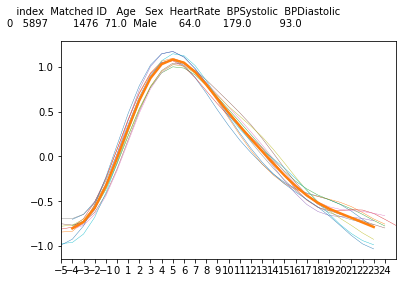

(900, 1200)

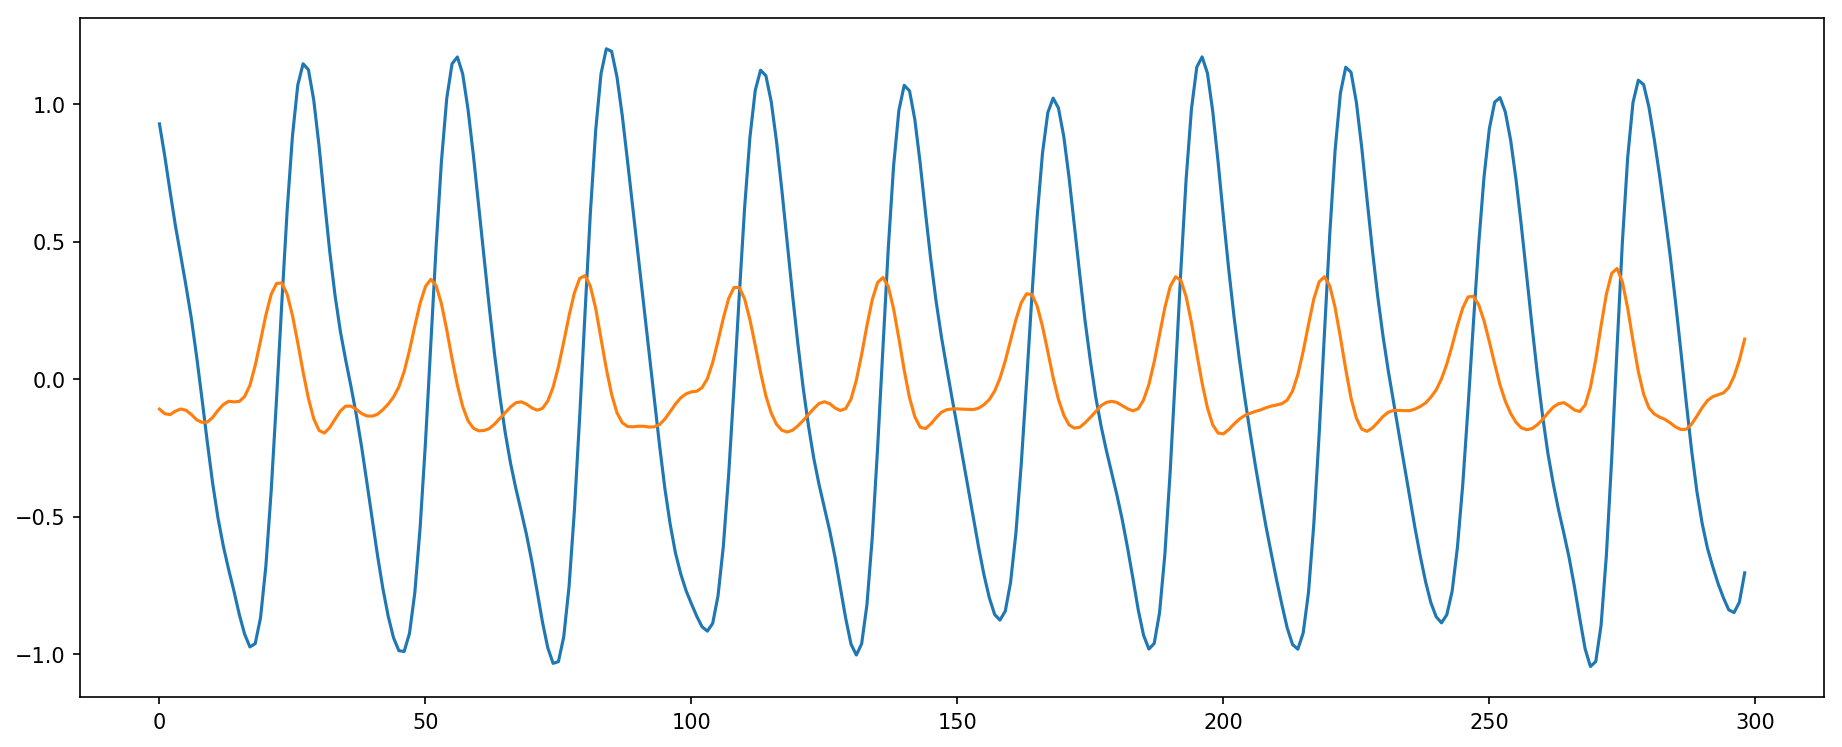

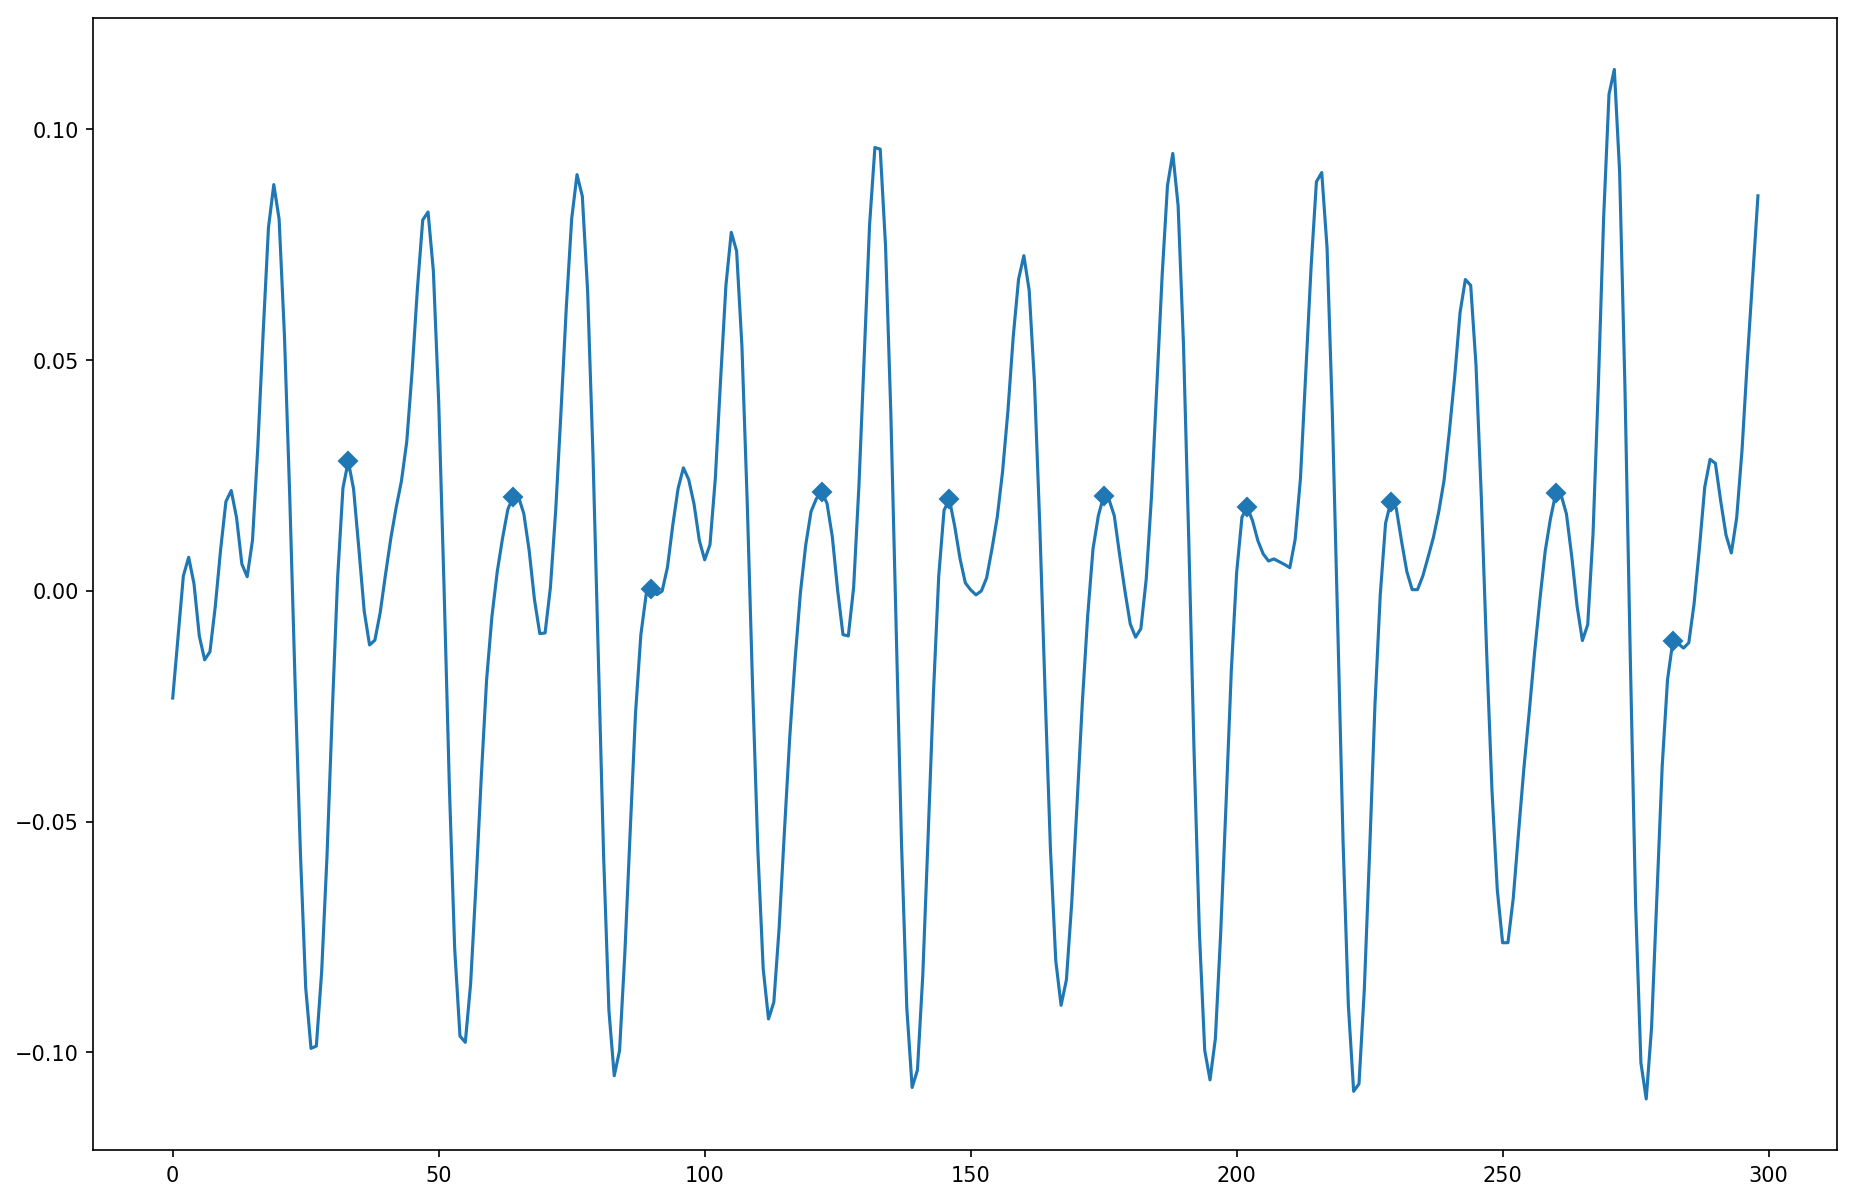

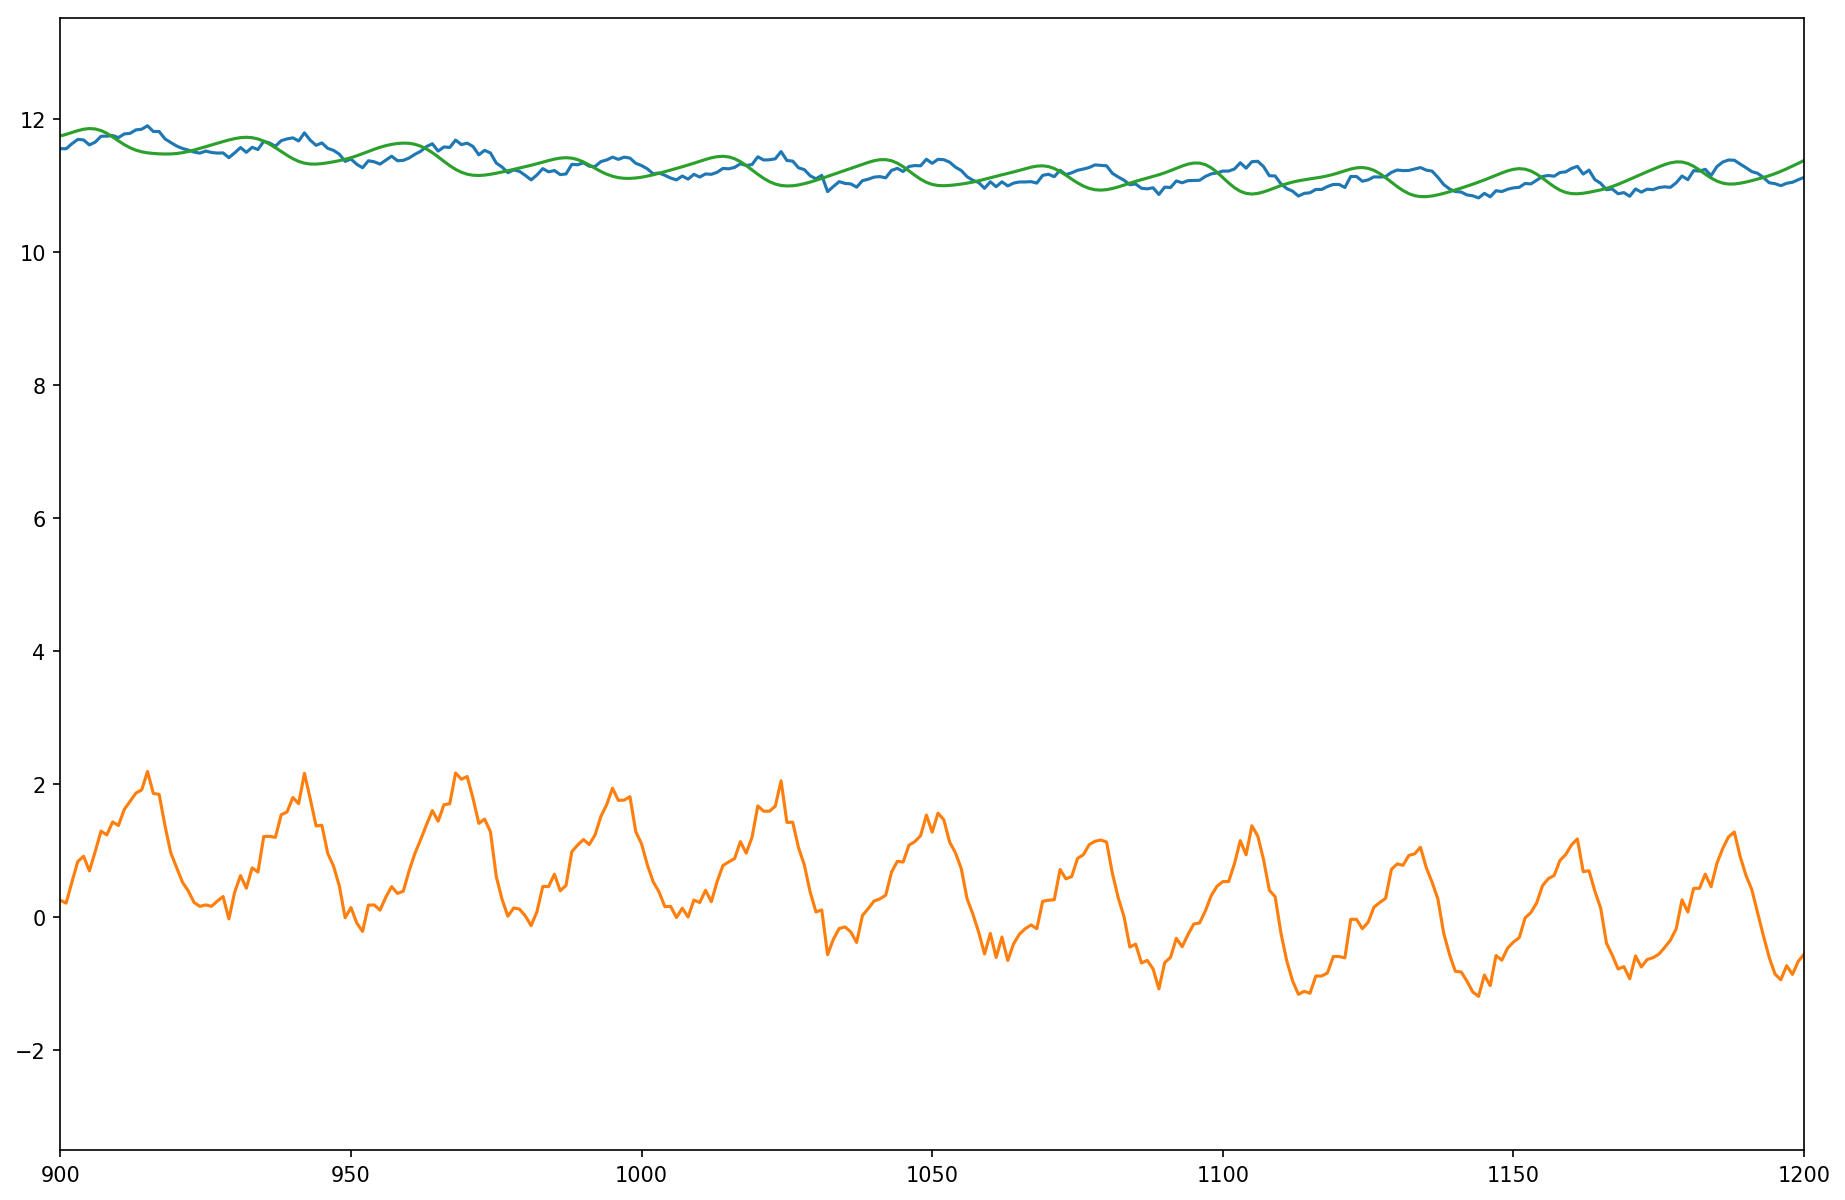

In [102]:
timeSeries={}
input={}
"""
sample1ids = [1430,1223,4798,4545,4541,4502,4412,4398,8051
,4100,3507,3366,3350,3311,3346,3154,3148,7757
,7271,6874,6422,6456,6501,6361,7899,7924,6128
,4386,3884,3741,4547,3591,3516,3412,3358,3268
,2291,2231,1526,8268,8192,7610,7719,4687,4676
,3939,3588,4258,2741,2041,1989,1696,1530,4489
,6950,6846,6621,6213,6150,6072,5160,2423,2258
,6620,6174,4664,4724,3841,8258,6355,3562,3306,
7398,7125,7049,6212,6557,7070,4760,3821,5480]
"""

"""
sample2ids =[8032,6315,7695,2479,
1543,2655,2396,7935,
7863,7942,3301,4478,
3534,3519,3887,
7122,7580,5752,2431,
3596,2597,1991,2165,
2594,2309,3938,2269,
7715,6639,6197,4818,4925,
4595,5159,8148,6719,4248,3247,5028,2208,6046,2636,5253,3310,3309,3966,
1430,1223,4798,4545,4541,4502,4412,4398,8051
,4100,3507,3366,3350,3311,3346,3154,3148,7757
,7271,6874,6422,6456,6501,6361,7899,7924,6128
,4386,3884,3741,4547,3591,3516,3412,3358,3268
,2291,2231,1526,8268,8192,7610,7719,4687,4676
,3939,3588,4258,2741,2041,1989,1696,1530,4489
,6950,6846,6621,6213,6150,6072,5160,2423,2258
,6620,6174,4664,4724,3841,8258,6355,3562,3306,
7398,7125,7049,6212,6557,7070,4760,3821,5480]
"""
sample3 = [7665,1564,8304,8127,7594,8131,7591,7428,7167,
          7009,3706,3600,8376,8310,8130,7815,7575,6408,
          5078,5198,5057,4979,4745,5577,5396,5399,8294,
          5183,4857,4792,4808,4677,3708,3662,2428,2021, 4813,
          6690,6435,6155,5787,5762,5584,5210,4731,3385,
            4696,3517,3304,1284,7806,7235,6642,5258,5041,
          7714,6640,6307,4712,4174,4074,3943,7188,4589,
          3659,4843,3744,5047,3820,7124,6789,5027,4762,
          6211, 5778]

combinedIDs = [8032,6315,7695,2479,
1543,2655,2396,7935,7863,7942,3301,4478,
3534,3519,3887,7122,7580,5752,2431,3596,2597,1991,2165,
2594,2309,3938,2269,7715,6639,6197,4818,4925
,4595,5159,8148,6719,4248,3247,5028
,2208,6046,2636,5253,3310,3309,3966,
1430,1223,4798,4545,4541,4502,4412,4398,8051
,4100,3507,3366,3350,3311,3346,3154,3148,7757
,7271,6874,6422,6456,6501,6361,7899,7924,6128
,4386,3884,3741,4547,3591,3516,3412,3358,3268
,2291,2231,1526,8268,8192,7610,7719,4687,4676
,3939,3588,4258,2741,2041,1989,1696,1530,4489
,6950,6846,6621,6213,6150,6072,5160,2423,2258
,6620,6174,4664,4724,3841,8258,6355,3562,3306,
7398,7125,7049,6212,6557,7070,4760,3821,5480,
7665,1564,8304,8127,7594,8131,7591,7428,7167,
7009,3706,3600,8376,8310,8130,7815,7575,6408,
5078,5198,5057,4979,4745,5577,5396,5399,8294,
5183,4857,4792,4808,4677,3708,3662,2428,2021,
4813,6690,6435,6155,5787,5762,5584,5210,4731,3385,
4696,3517,3304,1284,7806,7235,6642,5258,5041,
7714,6640,6307,4712,4174,4074,3943,7188,4589,
3659,4843,3744,5047,3820,7124,6789,5027,4762,
6211,5778]

ids = [1476]

for i in ids:
    
    beatsKept = 0
    totalBeats = 0
    id = i
    print(id)
    bioMetrics = df2.loc[df2['Matched ID']==id].reset_index()
    example = readings.loc[readings['testId'].isin([id]),'timestamp':'blue']
    
    input_array = [[],[],[]]
    # Determine the sampling rate - Assumed to be 30 fps anyway 
    signalLength = len(example)
    samplingRate = round(signalLength/60)
    
    # Green, blue, red, timestamps
    green = example['green'].values
    blue = example['blue'].values
    red = example['red'].values
    timestamps = tuple(example["timestamp"][3:])
    
    # Correct format for ICA
    input_array[0].append(green)
    input_array[1].append(blue)
    input_array[2].append(red)
    input_array = np.asarray(input_array)
    valuesNormalised = normalize_matrix(input_array)
    
    # The alternative to using ICA is using G-B
    ICA = jade.main(input_array)
    
    components = []
    components.append(np.squeeze(np.asarray(ICA[:, 0])).tolist())
    components.append(np.squeeze(np.asarray(ICA[:, 1])).tolist())
    components.append(np.squeeze(np.asarray(ICA[:, 2])).tolist())
    
    # Sometime blue pixel values will be greater than green this should be marked, when correlating 
    cleanSignal = raisedcosLPF(subGB(green,blue))
    cleanSignal = cheby2Filter(subGB(green,blue),4,4.0,40)
    # Needs error checking - Start the correlation 10 seconds from the start of the signal
    # To pick the best ICA component
    correlationCoefficients = []
    
    for component in components:
        correlationCoefficients.append(np.corrcoef(cheby2Filter(component,high=4.0,attenuation=40)[150:]
                                                   ,cheby2Filter(subGB(green,blue),high=4.0,attenuation=40)[150:])[1][0])
    
    maxCorrelationIndex = np.argmax([abs(number) for number in correlationCoefficients])
    # FFT method - Alternative to picking the best component using cross correlation (Not currently in use)
    # Should definitly be considered going forwards, cross correlation doesn't seem to always pick the best ICA component
    # Cross correlation method can tell if the signal has been flipped as a result of ICA i.e if coefficient is negative
    
    maxValues=[] 
    f_s = samplingRate
    freqs=np.fft.fftfreq(len(components[0]),d=1/f_s)
    
    for component in components:
        y = abs(np.fft.fft(cheby2Filter(component,4,5.0,40)))
        maxValues.append(np.max(y[45:180]))
    
    maxFFTIndex = np.argmax(maxValues)
    # Flip signal if correlation coefficient is negative (Some issues...)
    flip = 1
    
    signal = flip*cheby2Filter(components[maxFFTIndex],4,5,40)
    #signal = flip*cheby2Filter(components[maxFFTIndex],4,4.0,40)
    """
    plt.plot(components[maxFFTIndex][300:600])
    plt.plot(signal[300:600])
    plt.show()
    """
    
    
    # Getting the foot locations from a filter of lower high cut frequency and also a higher stop band attenuation
    # This can either come from the pulse pipeline or the chosen component
    # If it comes from the pulse pipeline then the signal has to start from a different point
    locationNumber, validIntervals, interval, foot, fiducial = getIntervals(differentiator(list(cheby2Filter(components[maxFFTIndex],4,5,40))))
    n = sqi(locationNumber)
    SDNN = np.std(locationNumber)
    
    # Multiply foot locations by 4 due to signal upsampling
    footlocations = [(x) for x in foot]
    
    # Split later due to low noised differentiator starting three frames later 
    final = signal[3:]
    
    singleBeats = np.split(final,footlocations)
    foot = footlocations[1:]
    
    validWaveforms=[]
    validityMatrix=[]
    # Temporary variables
    validBeats=[]
    validList = []
    
    
    temporaryLength=0
    f=np.correlate(final[400:3600],final[400:3600],mode='full')
    y=f.size
    
    
    f=f[int(f.size/2):]
    #plt.plot(f)
    #plt.show()
    indexes=list(find_peaks(f,distance=30))
    length=indexes[0][0]
    
    """
    #This is the loop which iterates over all of the segmented beats
    #and splits the beats into approximately 10 second epochs.
    #Aswell as splitting into epochs. Each pulse is passed to validatePPGWaveform.
    #Where a few validity checks are performed
    """
    
    for idx, i in enumerate(singleBeats[2::]):
        if validate_ppg_single_waveform(i):
            validBeats.append([i[::],footlocations[idx]])
            validList.append(True)
        else:
            validList.append(False)
        temporaryLength+=len(i)
        
        if(temporaryLength>len(signal)/6):
            temporaryLength=0
            validWaveforms.append(validBeats)
            validityMatrix.append(validList)
            validBeats=[]
            validList=[]
    
    n = np.argmax([np.sum(x) for x in validityMatrix])
    array = [not elem for elem in validityMatrix[n]]
    quality=(len(validWaveforms[n])/np.sum(array))
    
    
    validWaveforms[n] = [row[0] for row in validWaveforms[n]]
    
    if quality<0.7:
        continue
    
    firstPeakLocations =[]
    for i in validWaveforms[n]:
        firstPeakLocations.append(np.argmax(np.diff(i)))
    
    #plt.figure(figsize=(10,10),dpi=150)
    #plt.subplot(2, 1, 1)
    number = 0
    series=[]
    
    for idx,i in enumerate(validWaveforms[n]):
        x = np.linspace(0-firstPeakLocations[idx],len(i)-1-firstPeakLocations[idx],len(i))
        if validate_ppg_single_waveform(i):
            series.append(pd.Series((i),index=x))
            plt.plot(x,(i[:]),linewidth=0.4)
            #plt.show()
        
    
    #plt.show()

    
    result = pd.concat(series, join='inner', axis=1)
    result = result.mean(axis=1)
    
    
    plt.plot(result.index , result.values, linewidth=2.5)
    plt.xticks(range(-5,25))
    plt.xlim([-5,25])
    plt.gcf().text(0, 1, str(bioMetrics), ha='left', va='top')
    plt.show()
    
    series=[]
    
    for idx,i in enumerate(validWaveforms[n]):
        x = np.linspace(0-firstPeakLocations[idx],len(i)-1-firstPeakLocations[idx],len(i))
        if validate_ppg_single_waveform(i):
            series.append(pd.Series(savgol_filter(i,window_length=5,polyorder=3,deriv=2),index=x))    
    
   
      
    result = pd.concat(series, join='inner', axis=1)
    result = result.mean(axis=1)
    
    
    """"
    plt.plot(result.index , result.values, linewidth=2.5)
    plt.gcf().text(0, 1, str(bioMetrics), ha='left', va='top')
    plt.show()
    plt.savefig(f'AverageWaveforms//2ndwaveform_id_{id}.png')
    plt.close()
    """
    
    # Used for the alternative feature set from TSFresh
    # TS Fresh derives 800 or so features from a 10 second epoch
    # Some of these attributes may be of use at a later stage
    startingPoint = ((len(signal)//6)*(n+1))
    timeSeries[id] = signal[startingPoint:startingPoint+len(signal)//6]
    locationNumber, validIntervals, interval, foot, fiducial = getIntervals(differentiator(list(timeSeries[id])))
    
    fiducial= [x for x in fiducial]
    
    
    firstDerivative = savgol_filter(timeSeries[id],window_length=5,polyorder=3,deriv=1)
    secondDerivative = savgol_filter(timeSeries[id],window_length=5,polyorder=3,deriv=2)
    awaves, bwaves, cwaves, dwaves, fiducialA = getAandBwaves(secondDerivative,fiducial)
    
    fiducialA = np.median(fiducialA)
    
    """
    plt.subplot(2, 1, 2)
    plt.plot(secondDerivative,color = 'green', marker='D', markevery=(awaves))
    plt.plot(secondDerivative,color ='blue', marker='D', markevery=(bwaves))
    plt.plot(secondDerivative,marker='D', markevery=(cwaves))
    #plt.plot(firstDerivative)
    plt.gcf().text(0, 1, str(bioMetrics), ha='left', va='top')

    plt.savefig(f'AverageWaveforms//Averagewaveform_id_{id}.png')
    plt.show()
    """
    
    a = itemgetter(*awaves)(secondDerivative)
    b = itemgetter(*bwaves)(secondDerivative)
    c = itemgetter(*cwaves)(secondDerivative)
    d = itemgetter(*dwaves)(secondDerivative)
    
    ratio = [b / a for b,a in zip(b,a)]
    ratioTwo = [c / a for c,a in zip(c,a)]
    b_a = (reject_outliers(np.array(ratio)))
    d_a = (reject_outliers(np.array(ratioTwo)))
    
    #input[id] = {"b/a" : np.average(b_a),"d/a..":np.average(d_a),"SDNN":SDNN,"fiducial":fiducialA,"dbw75":average[0]}
    #input[id] = {"b/a" : np.median(ratio),"SDNN":SDNN,"fiducial":fiducialA,"a" :np.median(a), "b" : np.median(b)}
    intermediate = [extract_ppgFeatures(zscore(x)) for x in validWaveforms[n]]
  
    # trial code for outlier exclusion within the feature set due to 
    # to the inadequacy of the current method of feature extraction
    transposed = np.transpose(intermediate)
    outlierExclusion = [np.array(reject_outliers(x)) for x in transposed]
    average = [np.average(x) for x in outlierExclusion]
    input[id] = {"b/a" : np.median(ratio),"SDNN":SDNN,"fiducial":fiducialA,"c/a":np.median(ratioTwo),
                 "dbw75":average[0],"dbw66":average[1],"dbw50":average[2],"dbw33":average[3],"dbw25":average[4],"dbw10":average[5],
                 "rbw75":average[6],"rbw66":average[7],"rbw50":average[8],"rbw33":average[9],"rbw25":average[10],"rbw10":average[11],
                 "a" :np.median(a), "b" : np.median(b), "RatioOfAreas":average[12]}

beatsKept += np.sum(validityMatrix[n])
totalBeats += len(validityMatrix[n])
plt.figure(figsize=(15,6),dpi=150)
plt.plot(timeSeries[id])
plt.plot(firstDerivative)

plt.figure(figsize=(15,10),dpi=150)
plt.plot(secondDerivative,marker='D', markevery=(cwaves))

plt.figure(figsize=(15,10),dpi=150)
plt.plot(green-blue)
plt.plot(components[maxFFTIndex])
plt.plot(raisedcosLPF(green-blue))
plt.xlim(900,1200)






In [ ]:
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

print(len(input))

df = pd.DataFrame.from_dict(input,orient='index')
df2 = pd.read_csv("C:\\Users\\James\\PycharmProjects\\XimSampleData\\UserData3.csv")
df2.set_index('Matched ID', inplace=True)
#df3 = pd.DataFrame.from_dict(new_data, orient='index')
df3 = pd.concat([df2,df],axis=1,join="inner")
#df3.to_csv("C:\\Users\\James\\PycharmProjects\\XimSampleData\\127_sample_b_aButter.csv")
def corrfunc(x, y, **kws):
    return stats.pearsonr(x, y)[0]

#age = df3['Age'].values
#minMaxScaler = MinMaxScaler()
#age = minMaxScaler.fit_transform(age)
#scaler.transform(age)
#df3['Age'] = age
df3['(b/a)*age']= df3['b/a'] * df3['Age']
df3['PP']=df3['BPSystolic']-df3['BPDiastolic']

print(df3.columns)
for column in df3:
    if df3[column].dtype == np.float64 or df3[column].dtype == np.int64:
        sns.jointplot(df3[column],df3['BPSystolic'],stat_func=corrfunc, kind='reg')
        plt.show()

sns.jointplot(df3['BPSystolic'],df3['(b/a)*age'],stat_func=corrfunc, kind='reg')
sns.jointplot(df3['BPSystolic'],df3['Age'],stat_func=corrfunc, kind='reg')


df3.to_csv("C:\\Users\\James\\PycharmProjects\\XimSampleData\\DatasetwithWidthFeatures.csv")

In [ ]:
from matplotlib.widgets import Button
from matplotlib.text import Annotation
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

from matplotlib.cbook import get_sample_data

%matplotlib qt


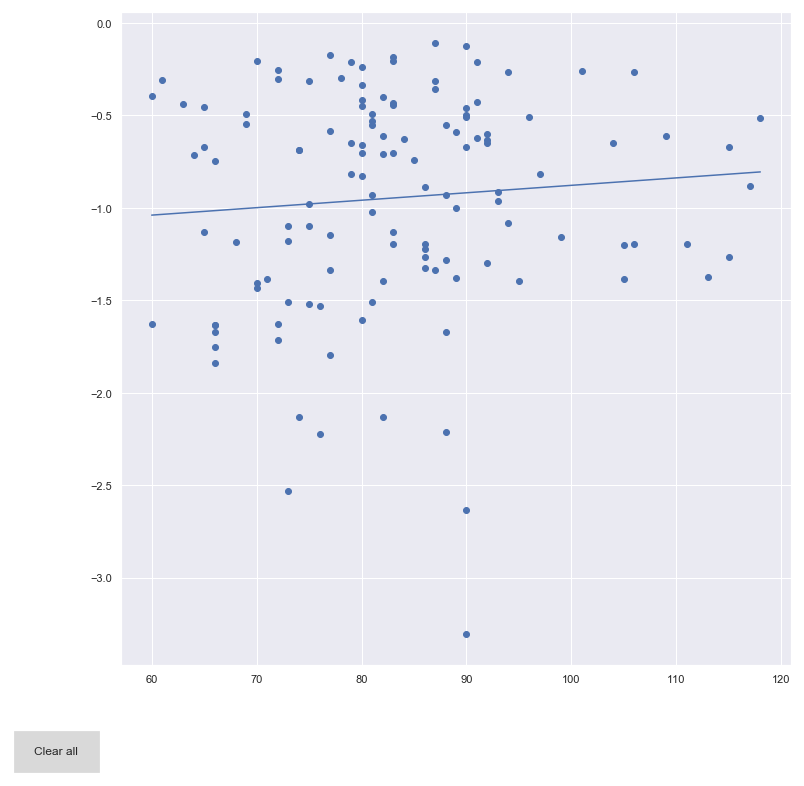

In [21]:

sns.set()

fig = plt.figure(figsize=(12, 12))
ax = plt.subplot()

axis_values_x=df3['BPDiastolic']
axis_values_y=df3['b/a']

generated_labels = ["{0}".format(i) for i in df3.index]

def draw_scatterplot():
    ax.scatter(
        axis_values_x,
        axis_values_y,
        picker=True
    )
    """
    ax.set_xlim([75,225])
    ax.set_ylim([-1.6,-0.4])
    """
    ax.plot(
        np.unique(axis_values_x), 
        np.poly1d(np.polyfit(axis_values_x, axis_values_y, 1))(np.unique(axis_values_x)))

draw_scatterplot()


def annotate(axis, text, x, y):
    text_annotation = Annotation(text, xy=(x, y), xycoords='data')
    axis.add_artist(text_annotation)
    
    
def annotate_image(axis, image,x ,y):
    image_annotations = AnnotationBbox(image,xy = (x,y), xycoords='data',
                                       boxcoords="offset points",
                                       pad=0.5)
    
    axis.add_artist(image_annotations)

    

def onpick(event):
    # step 1: take the index of the dot which was picked
    ind = event.ind

    # step 2: save the actual coordinates of the click, so we can position the text label properly
    label_pos_x = event.mouseevent.xdata
    label_pos_y = event.mouseevent.ydata

    # just in case two dots are very close, this offset will help the labels not appear one on top of each other
    offset = 0

    # if the dots are to close one to another, a list of dots clicked is returned by the matplotlib library
    for i in ind:
        # step 3: take the label for the corresponding instance of the data
        label = generated_labels[i]

        # step 4: log it for debugging purposes
        print("index", i, label)
        fn = get_sample_data(f"C:\\Users\\James\\PycharmProjects\\AverageWaveforms\\Averagewaveform_id_{label}.png", asfileobj=False)
        arr_img = plt.imread(fn, format='png')
        imagebox = OffsetImage(arr_img, zoom=0.6)
        imagebox.image.axes = ax
        
        # step 5: create and add the text annotation to the scatterplot
        """"
        annotate(
            ax,
            label,
            label_pos_x + offset,
            label_pos_y + offset
        )
        """
        
        annotate_image(
            ax,
            imagebox,
            label_pos_x ,
            label_pos_y 
           
        )
        
        # step 6: force re-draw
        ax.figure.canvas.draw_idle()

        # alter the offset just in case there are more than one dots affected by the click
        offset += 0.01

fig.canvas.mpl_connect('pick_event', onpick)

ax_clear_all = plt.axes([0.0, 0.0, 0.1, 0.05])
button_clear_all = Button(ax_clear_all, 'Clear all')

def onclick(event):
    # step 1: we clear all artist object of the scatter plot
    ax.cla()

    # step 2: we re-populate the scatterplot only with the dots not the labels
    draw_scatterplot()

    # step 3: we force re-draw
    ax.figure.canvas.draw_idle()


button_clear_all.on_clicked(onclick)

# initial drawing of the scatterplot
plt.plot()
# present the scatterplot
plt.show()


Index(['Age', 'Sex', 'HeartRate', 'BPSystolic', 'BPDiastolic', 'b/a', 'd/a..',
       '(b/a)*age', 'PP'],
      dtype='object')
